<h1 align=center> New Cafe site in Mumbai </h1>

<h2> Battle of the Neighborhoods: Find an appropriate site to open a Cafe in Mumbai</h2>
<br><br><h3> Let's first discuss the initial steps that we need to perform to find out an appropriate Cafe Site in Mumbai</h3><br>
<br><b>Tasks:</b> 
<ui>
    <li>Scrape Mumbai postal code information from wikipedia website.</li>
    <li>Load the data into a dataframe where data is wrangled, cleaned and transformed into a final dataframe.</li>
    <li>Populate the dataframe with Mumbai Area, Locations and Latitude and Longitude information.</li>
</ui>
<br> <br>Let's begin by building code to scrape following wikipedia page, <href>https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai</href>, to get our Area, Location and Geocode data. Then we'll wrangle and clean the data.

In [4]:
# Load url into data objects for analysis: 
import pandas as pd #library for data analysis
geodata = pd.read_html("https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai")
geodata = geodata[0]
geodata.head()

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


In [5]:
dup_chk = geodata.apply(lambda col: col.duplicated()).sum()
print(dup_chk)

Area          0
Location     62
Latitude      8
Longitude    11
dtype: int64


The dup_chk lambda function above returned a 0 sum of Area column duplicates, therefore no condition of two or more Locations sharing same Area value exists within dataframe.
<br>
Let's get the shape of the dataframe to see how many areas are there in Mumbai

In [6]:
print(geodata.shape)

(93, 4)


The shape of <b>geodata</b> is <b>93 x 4</b> inidicating <b>93 rows</b> and <b>4 columns</b>.

<h3>Now that we have our data, lets discuss the further tasks that we need to perform to find out the Cafe Site in Mumbai</h3>
<br><b>Tasks:</b> 
<ui>
    <li>Validate the Data</li>
    <li>Setup FourSquare Parameters</li>
    <li>Search for Coffee Places in API Response</li>
    <li>Explore Neighborhoods in Mumbai</li>
    <li>Visualize the Areas with Least No. of Coffee Shops! </li>
</ui>
<br> <br>

In [15]:
import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes #uncomment this line geopy is not already installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium #Uncomment this line if Folium is not already installed.
import folium #map rendering library

print('Libraries imported.')

Libraries imported.


### Validate the data in geodata dataframe.

In [16]:
geodata.head(5)

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


Access first Area <b>( location = 0 )</b>

In [17]:
geodata.loc[0,'Area']

'Amboli'

Calculate the No. of Areas and Locations.

In [18]:
print('The dataframe has {} Areas and {} Locations.'.format(
        len(geodata['Area'].unique()),
        geodata.shape[0]
    )
)

The dataframe has 93 Areas and 93 Locations.


Check Latitude and Longitude values in <b>geodata</b> dataframe for first row <b>( location = 0 )</b>.

In [19]:
geodata_latitude = geodata.loc[0, 'Latitude'] # neighborhood latitude value
geodata_longitude = geodata.loc[0, 'Longitude'] #neighborhood longitude value
geodata_neighborhood = geodata.loc[0,'Area'] #neighborhood features

print('Latitude and longitude values of {} are {}, {}.'.format(geodata_latitude, 
                                                               geodata_longitude, 
                                                               geodata_neighborhood))

Latitude and longitude values of 19.1293 are 72.8434, Amboli.


<h3> Setting up Foursquare parameters </h3>

In [20]:
CLIENT_ID = '5OQL5M4KECANV0WRRLY2UCVKFOMR0POSP1YSZ2UHTQTIL5XO' # your Foursquare ID
CLIENT_SECRET = 'T11ZR5ZZLK0MXZWV02IYDL1H32ND00SJXDQDGSCMQLBO0DLW' # your Foursquare Secret
VERSION = '20200812'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5OQL5M4KECANV0WRRLY2UCVKFOMR0POSP1YSZ2UHTQTIL5XO
CLIENT_SECRET:T11ZR5ZZLK0MXZWV02IYDL1H32ND00SJXDQDGSCMQLBO0DLW


Plot the map of Mumbai using the latitudes and longitudes of Mumbai.

In [21]:
# Next we create map of Mumbai using latitude and longitude values and add markers to map and start exploring visuals.
latitude='19.076'
longitude='72.8777'
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, area, location in zip(geodata['Latitude'], geodata['Longitude'], 
                                           geodata['Area'], geodata['Location']):
    label = '{}, {}'.format(area, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai

Neighbourhood names can be viewed by making mouse selection on markers.

<h3> Search for Coffee Places in API Response</h3>

> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

<br>Let's define a query to search for Coffee places that are within 2Kms from the Mumbai Coordinates.

In [27]:
search_query = 'Coffee'
print(search_query + ' .... OK!')

Coffee .... OK!


Define the corresponding URL

In [28]:
radius=2000
LIMIT=20
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=5OQL5M4KECANV0WRRLY2UCVKFOMR0POSP1YSZ2UHTQTIL5XO&client_secret=T11ZR5ZZLK0MXZWV02IYDL1H32ND00SJXDQDGSCMQLBO0DLW&ll=19.076,72.8777&v=20200812&query=Coffee&radius=2000&limit=20'

Send the GET Request and examine the results

In [29]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f35665d2f553b56238ce80a'},
 'response': {'venues': [{'id': '4f27c1e710819d468977eb3e',
    'name': 'Di Bella Coffee',
    'location': {'address': 'Phoenix Market City, LBS Marg, Near BKC, Kurla West',
     'lat': 19.086625644178234,
     'lng': 72.88988706779166,
     'labeledLatLngs': [{'label': 'display',
       'lat': 19.086625644178234,
       'lng': 72.88988706779166}],
     'distance': 1744,
     'postalCode': '400070',
     'cc': 'IN',
     'city': 'Mumbai',
     'state': 'Mahārāshtra',
     'country': 'India',
     'formattedAddress': ['Phoenix Market City, LBS Marg, Near BKC, Kurla West',
      'Mumbai 400070',
      'Mahārāshtra',
      'India']},
    'categories': [{'id': '4bf58dd8d48988d1e0931735',
      'name': 'Coffee Shop',
      'pluralName': 'Coffee Shops',
      'shortName': 'Coffee Shop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
       'suffix': '.png'},
      'primary': True}],
    'ref

Get relevant part of JSON and transform it into a *pandas* dataframe

In [30]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.name.head()

0               Di Bella Coffee
1    The Coffee Bean & Tea Leaf
2               Cafe Coffee Day
3                  Costa Coffee
4               Di Bella Coffee
Name: name, dtype: object

In [31]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={},&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,'20200811',"Mira Road",3000,50)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=5OQL5M4KECANV0WRRLY2UCVKFOMR0POSP1YSZ2UHTQTIL5XO&client_secret=T11ZR5ZZLK0MXZWV02IYDL1H32ND00SJXDQDGSCMQLBO0DLW&v=20200811&near=Mira Road,&radius=3000&limit=50'

In [32]:
results = requests.get(url).json()
results
venues

[{'id': '4f27c1e710819d468977eb3e',
  'name': 'Di Bella Coffee',
  'location': {'address': 'Phoenix Market City, LBS Marg, Near BKC, Kurla West',
   'lat': 19.086625644178234,
   'lng': 72.88988706779166,
   'labeledLatLngs': [{'label': 'display',
     'lat': 19.086625644178234,
     'lng': 72.88988706779166}],
   'distance': 1744,
   'postalCode': '400070',
   'cc': 'IN',
   'city': 'Mumbai',
   'state': 'Mahārāshtra',
   'country': 'India',
   'formattedAddress': ['Phoenix Market City, LBS Marg, Near BKC, Kurla West',
    'Mumbai 400070',
    'Mahārāshtra',
    'India']},
  'categories': [{'id': '4bf58dd8d48988d1e0931735',
    'name': 'Coffee Shop',
    'pluralName': 'Coffee Shops',
    'shortName': 'Coffee Shop',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1597335222',
  'hasPerk': False},
 {'id': '4f84d127e4b064ded71cd047',
  'name': 'The Coffee Bean & Tea Leaf',
  'location': {'

Let's borrow the <b>get_category_type</b> function from the Foursquare lab.

In [33]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the <b>json</b> and structure it into a <i>pandas</i> dataframe

In [34]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,GCC Club,Gym / Fitness Center,19.282988,72.878259
1,Ratnagiri Malwani Food,Indian Restaurant,19.287782,72.864578
2,Vardhman Fantasy,Sculpture Garden,19.289466,72.866234
3,McDonald's,Fast Food Restaurant,19.287089,72.867445
4,N. L. Dalmia Institute of Management Studies a...,General College & University,19.269679,72.870757


Calculate <b>No. of Venues</b> returned by Foursquare API.

In [35]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

48 venues were returned by Foursquare.


<h3>Explore Neighborhoods in Mumbai</h3>

Let's create a function to repeat the same process to all the neighborhoods in Mumbai.
<br> Let's borrow <b>get_venues</b> function from the course lab.

In [36]:

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
   
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [37]:

def get_venue_details(venue_id):
        
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### The below function prepares neighborhood list that contains 'Coffee Shop'

In [38]:
column_names=['Area','ID','Location','Name','Count']
coffee_places=pd.DataFrame(columns=column_names)
count=1
for row in geodata.values.tolist():
    Area, Location, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    coffee=venues[venues['Category']=='Coffee Shop']   
    #print('(',count,'/',len(geodata),')','Coffee Place in '+Area+', '+Area+':'+str(len(coffee)))
    for coffee_detail in coffee.values.tolist():
        id, name , category=coffee_detail
        coffee_places = coffee_places.append({'Area': Area,
                                                'ID': id,
                                                'Location': Location,
                                                'Name' : name,
                                                'Count': str(len(coffee)),
                                               }, ignore_index=True)
    count+=1

In [39]:
coffee_places.head(10)

,Area,ID,Location,Name,Count
0,Amboli,4cfa068ac6cca35d13dd8332,"Andheri,Western Suburbs",Cafe Coffee Day,2
1,Amboli,4b9fb2aff964a520013637e3,"Andheri,Western Suburbs",Cafe Coffee Day,2
2,D.N. Nagar,4cfa068ac6cca35d13dd8332,"Andheri,Western Suburbs",Cafe Coffee Day,2
3,D.N. Nagar,4dfb3841b61c6408772e6dd6,"Andheri,Western Suburbs",Cafe Coffee Day,2
4,Four Bungalows,4df0d576c65b0270f3a54a0b,"Andheri,Western Suburbs",Cafe Coffee Day,3
5,Four Bungalows,4c63efb4e13495218be3c9f0,"Andheri,Western Suburbs",cafe coffee day,3
6,Four Bungalows,4dfb3841b61c6408772e6dd6,"Andheri,Western Suburbs",Cafe Coffee Day,3
7,Lokhandwala,4dfb3841b61c6408772e6dd6,"Andheri,Western Suburbs",Cafe Coffee Day,6
8,Lokhandwala,4df0d576c65b0270f3a54a0b,"Andheri,Western Suburbs",Cafe Coffee Day,6
9,Lokhandwala,4c63efb4e13495218be3c9f0,"Andheri,Western Suburbs",cafe coffee day,6


In [40]:
coffee_places.shape

(161, 5)

#### Let's plot a Bar Graph to see the No. of Coffee Places in Mumbai

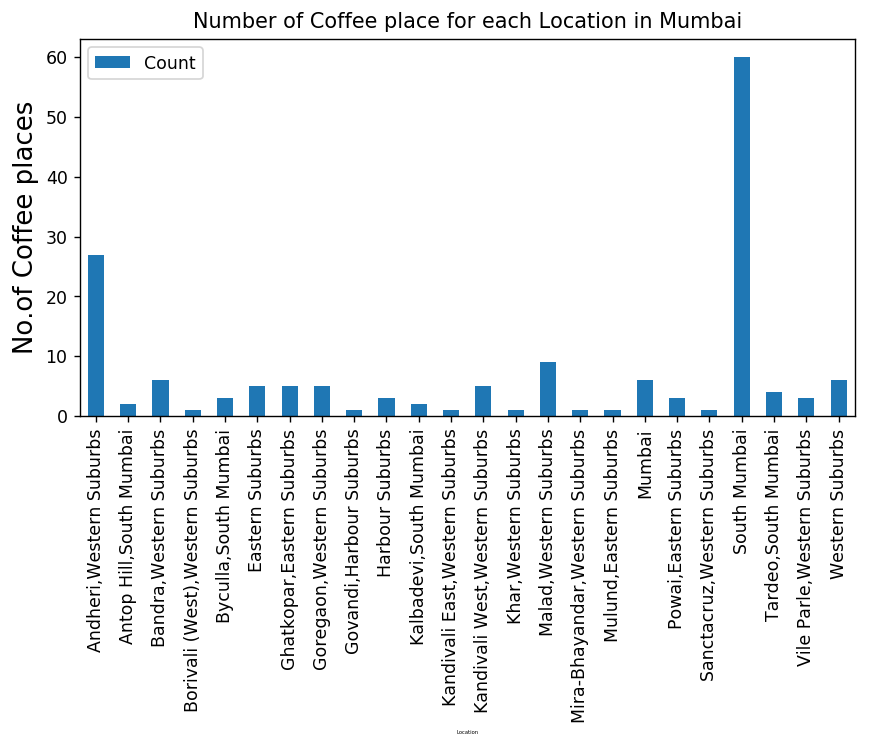

In [41]:
plt.figure(figsize=(8,4), dpi=125)
# title
plt.title('Number of Coffee place for each Location in Mumbai')
#On x-axis
plt.xlabel('Location', fontsize = 3)
#On y-axis
plt.ylabel('No.of Coffee places', fontsize=15)
#giving a bar plot
coffee_places.groupby('Location')['Count'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### Let's see the TOP 5 Locations with maximum Coffee places in Mumbai

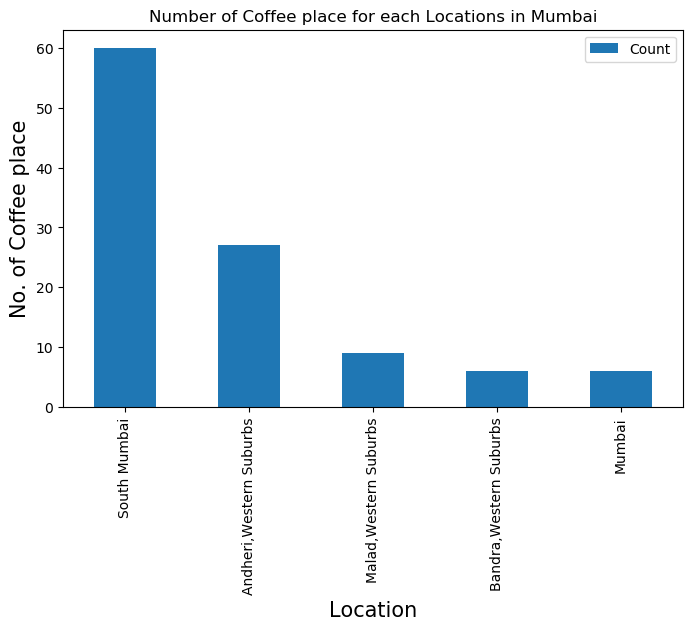

In [43]:
plt.figure(figsize=(8,5), dpi=100)
# title
plt.title('Number of Coffee place for each Locations in Mumbai')
#On x-axis
plt.xlabel('Location', fontsize = 15)
#On y-axis
plt.ylabel('No. of Coffee place', fontsize=15)
#giving a bar plot
coffee_places.groupby('Location')['Count'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the above graph, we see that <b>South Mumbai</b> has the most No. of Coffee Places in Mumbai.

In [57]:
coffee_places[['Count']]=coffee_places[['Count']].astype('float64')
coffee_places.head()

,Area,ID,Location,Name,Count
0,Amboli,4cfa068ac6cca35d13dd8332,"Andheri,Western Suburbs",Cafe Coffee Day,2.0
1,Amboli,4b9fb2aff964a520013637e3,"Andheri,Western Suburbs",Cafe Coffee Day,2.0
2,D.N. Nagar,4cfa068ac6cca35d13dd8332,"Andheri,Western Suburbs",Cafe Coffee Day,2.0
3,D.N. Nagar,4dfb3841b61c6408772e6dd6,"Andheri,Western Suburbs",Cafe Coffee Day,2.0
4,Four Bungalows,4df0d576c65b0270f3a54a0b,"Andheri,Western Suburbs",Cafe Coffee Day,3.0


In [58]:
least_coffee=coffee_places.groupby('Area',as_index=False).mean()[['Area','Count']]
least_coffee.columns=['Area','Average Count']
least_coffee.head(10)
least_coffee.sort_values(['Average Count'],ascending=False).head(10)

,Area,Average Count
57,Sahar,8.0
59,Sunder Nagar,7.0
39,Lokhandwala,6.0
51,Nariman Point,5.0
63,Vidyavihar,5.0
6,Bangur Nagar,5.0
61,Thane,5.0
48,Matunga,4.0
42,Mahim,4.0
16,Churchgate,4.0


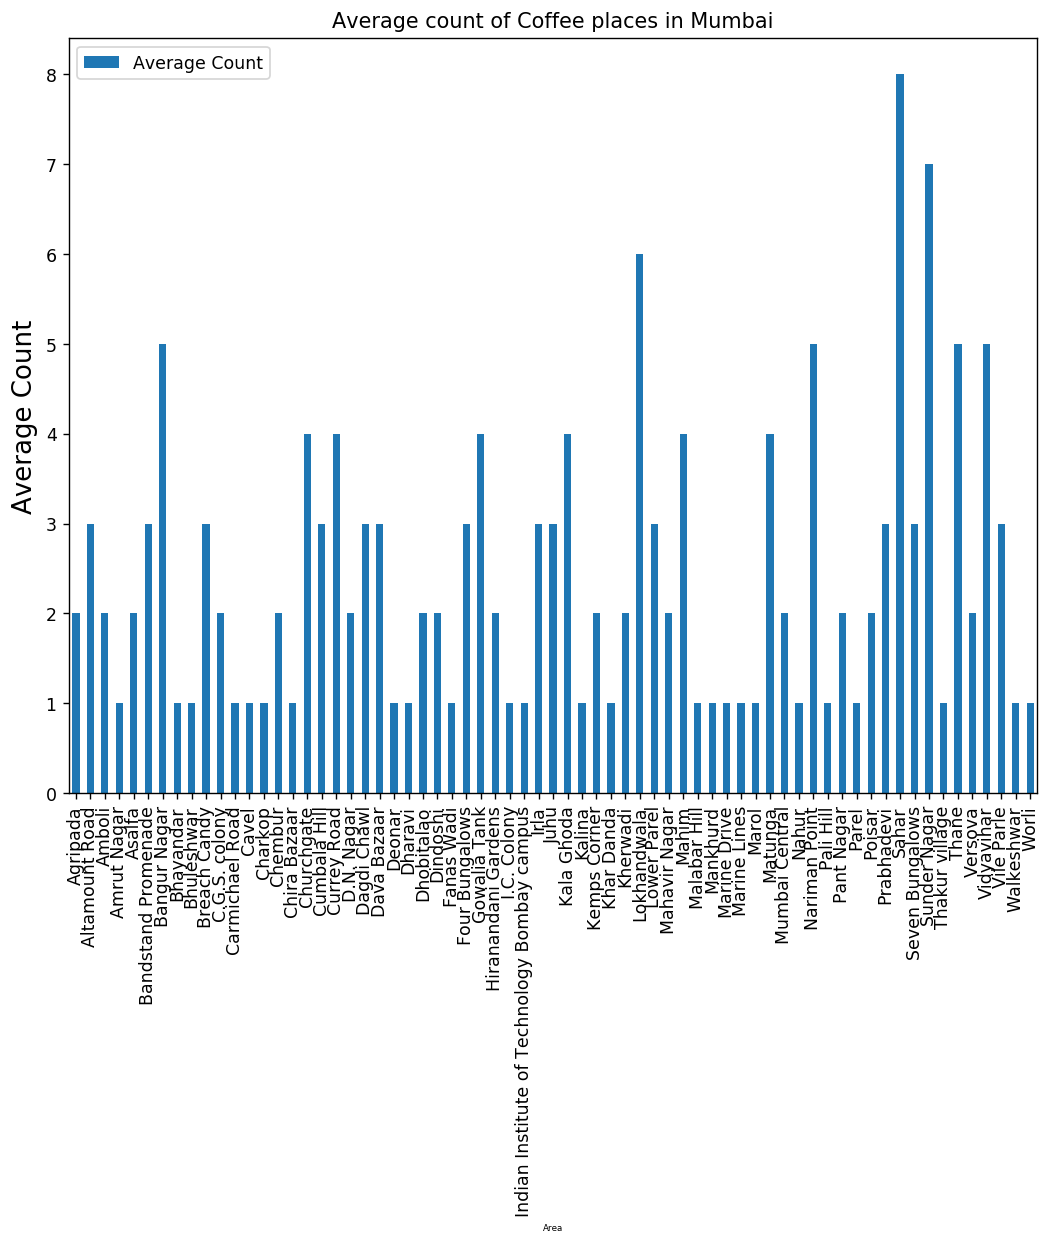

In [59]:
plt.figure(figsize=(10,8), dpi = 125)

plt.title('Average count of Coffee places in Mumbai')

plt.xlabel('Area', fontsize = 5)

plt.ylabel('Average Count', fontsize=15)

least_coffee.groupby('Area').mean()['Average Count'].plot(kind='bar')

plt.legend()

plt.show()

List of areas in which Coffee places counts are 2 or less than 2.

In [67]:
least_coffee=least_coffee[least_coffee['Average Count']<2.0]
least_coffee

,Area,Average Count
3,Amrut Nagar,1.0
7,Bhayandar,1.0
8,Bhuleshwar,1.0
11,Carmichael Road,1.0
12,Cavel,1.0
13,Charkop,1.0
15,Chira Bazaar,1.0
22,Deonar,1.0
23,Dharavi,1.0
26,Fanas Wadi,1.0


In [68]:
LC = pd.merge(least_coffee,geodata, on='Area')

In [69]:
LC=LC[['Area','Latitude','Longitude','Average Count']]
LC.head()

,Area,Latitude,Longitude,Average Count
0,Amrut Nagar,19.102077,72.912835,1.0
1,Bhayandar,19.290000,72.850000,1.0
2,Bhuleshwar,18.950000,72.830000,1.0
3,Carmichael Road,18.972200,72.811300,1.0
4,Cavel,18.947400,72.827200,1.0


### Visualize the Areas with Least No. of Coffee Shops!

In [70]:

incidents = folium.map.FeatureGroup()

for lat, lng, in LC[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [71]:
LC['Label']=LC['Area']+', '+'('+LC['Average Count'].map(str)+')'


#### Add pop-up text to each marker on the map

In [72]:

map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, label in LC[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(map_mumbai)        
# add incidents to map
map_mumbai.add_child(incidents)

In [73]:
LC = LC.sort_values(['Average Count'],ascending=False)
LC.head(10)

,Area,Latitude,Longitude,Average Count,Label
0,Amrut Nagar,19.102077,72.912835,1.0,"Amrut Nagar, (1.0)"
13,Khar Danda,19.068598,72.840042,1.0,"Khar Danda, (1.0)"
23,Walkeshwar,18.947596,72.795957,1.0,"Walkeshwar, (1.0)"
22,Thakur village,19.210206,72.872980,1.0,"Thakur village, (1.0)"
21,Parel,18.990000,72.840000,1.0,"Parel, (1.0)"
20,Pali Hill,19.068000,72.826000,1.0,"Pali Hill, (1.0)"
19,Nahur,19.157000,72.941000,1.0,"Nahur, (1.0)"
18,Marol,19.119219,72.882743,1.0,"Marol, (1.0)"
17,Marine Lines,18.944700,72.824400,1.0,"Marine Lines, (1.0)"
16,Marine Drive,18.944000,72.823000,1.0,"Marine Drive, (1.0)"


## Conclusion
### Below are the Best Areas to open an Pizza EatOuts:
<br>
<ui>
    <li>Amrut Nagar</li>
    <li>Khar Danda</li>
    <li>Walkeshwar</li>
    <li>Thakur Village</li>
    <li>Parel</li>
    <li>Pali Hill</li>
    <li>Nahur</li>
    <li>Marol</li>
    <li>Marine Lines</li>
    <li>Marine Drive</li>

### Limitations

#### The Count is highly dependent on Foursquare API details. There might be some other pizza eatouts which are not listed in foursquare database.